# Evaluation of text-to-image generation model with DSG

based on [Davidsonian Scene Graph: Improving Reliability in Fine-grained Evaluation for Text-Image Generation]() (2023)

We provide the step-by-step walkthrough of text-to-image evaluation with DSG

1) Load example image & text
2) Generate DSG questions with LLM
3) Answer questions with VQA + Average scores with DSG question dependency 

and a single method for end-to-end evaluation which is compatible with any LLM and VQA models.

## 1) Load example image & text

In [1]:
from PIL import Image
from pprint import pprint

In [2]:
INPUT_TEXT_PROMPT = "A baby is sleeping on a covered mattress. His shirt is black white and blue. The mattress cover has designs all over it. There is a doll with a blue and purple hoody nearby."

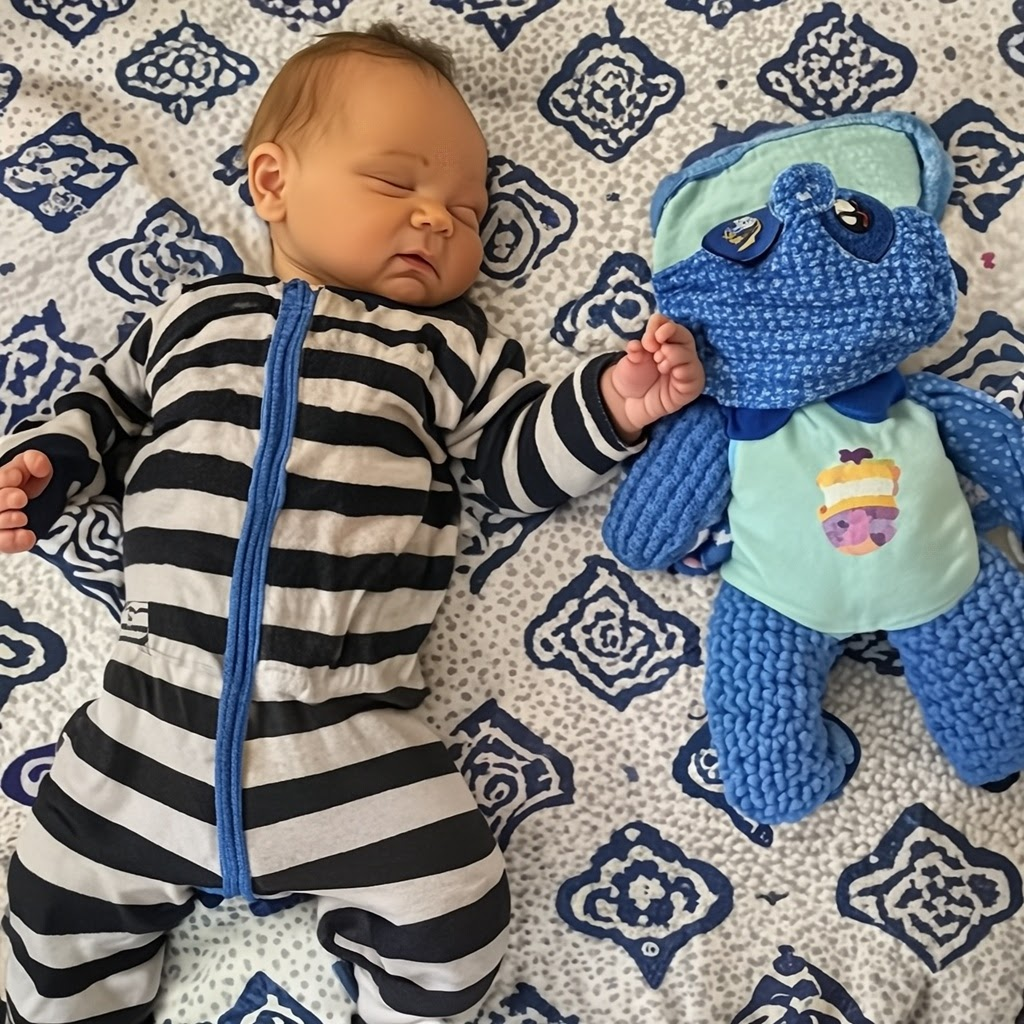

In [3]:
generated_image = Image.open("example_img.png")
generated_image

# 2) Generate DSG with LLM

For example, we use gpt-3.5-turbo-16k-0613 (https://platform.openai.com/docs/models/gpt-3-5).

In [4]:
import openai
from openai_utils import openai_setup, openai_completion

# Reading API KEY from _OAI_KEY.txt
openai_setup()

# You can manually set OpenAI API key below
# openai.api_key = ""

assert openai.api_key is not None

# Run example LLM call
openai_completion(
    'hello, how are you doing?'
    model='gpt-3.5-turbo-16k-0613'
)

"Hello! I'm an AI, so I don't have feelings, but I'm here to help you. How can I assist you today?"

In [5]:
from query_utils import generate_dsg

In [6]:
id2prompts = {
    'custom_0': {
        'input': INPUT_TEXT_PROMPT,
    }
}

id2tuple_outputs, id2question_outputs, id2dependency_outputs = generate_dsg(
    id2prompts,
    
    # you can change this method with any method that takes prompt as input and outputs LLM generation result.
    generate_fn=openai_completion
)

Task 1:  tuple
Run inference


Preparing LM inputs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 6502.80it/s]


Running LM calls with 1 workers.


Postprocessing LM outputs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15709.00it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'A baby is sleeping on a covered mattress. His shirt is black white '
          'and blue. The mattress cover has designs all over it. There is a '
          'doll with a blue and purple hoody nearby.',
 'output': '1 | entity - whole (baby)\n'
           '2 | entity - whole (mattress)\n'
           '3 | entity - whole (shirt)\n'
           '4 | attribute - color (shirt, black white and blue)\n'
           '5 | attribute - state (baby, sleeping)\n'
           '6 | attribute - state (mattress, covered)\n'
           '7 | attribute - texture (mattress cover, designs all over)\n'
           '8 | entity - whole (doll)\n'
           "9 | attribute - color (doll's hoody, blue and purple)\n"
           '10 | relation - spatial (doll, nearby)'}
Task 2:  question
Run inference


Preparing LM inputs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5302.53it/s]


Running LM calls with 1 workers.


Postprocessing LM outputs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12748.64it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'A baby is sleeping on a covered mattress. His shirt is black white '
          'and blue. The mattress cover has designs all over it. There is a '
          'doll with a blue and purple hoody nearby.\n'
          '1 | entity - whole (baby)\n'
          '2 | entity - whole (mattress)\n'
          '3 | entity - whole (shirt)\n'
          '4 | attribute - color (shirt, black white and blue)\n'
          '5 | attribute - state (baby, sleeping)\n'
          '6 | attribute - state (mattress, covered)\n'
          '7 | attribute - texture (mattress cover, designs all over)\n'
          '8 | entity - whole (doll)\n'
          "9 | attribute - color (doll's hoody, blue and purple)\n"
          '10 | relation - spatial (doll, nearby)',
 'output': '1 | Is there a baby?\n'
           '2 | Is there a mattress?\n'
           '3 | Is there a shirt?\n'
           '4 | Is the shirt black, white, and blue?\n'
           '5 | Is the baby sleeping

Preparing LM inputs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4588.95it/s]


Running LM calls with 1 workers.


Postprocessing LM outputs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14315.03it/s]

Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'A baby is sleeping on a covered mattress. His shirt is black white '
          'and blue. The mattress cover has designs all over it. There is a '
          'doll with a blue and purple hoody nearby.\n'
          '1 | entity - whole (baby)\n'
          '2 | entity - whole (mattress)\n'
          '3 | entity - whole (shirt)\n'
          '4 | attribute - color (shirt, black white and blue)\n'
          '5 | attribute - state (baby, sleeping)\n'
          '6 | attribute - state (mattress, covered)\n'
          '7 | attribute - texture (mattress cover, designs all over)\n'
          '8 | entity - whole (doll)\n'
          "9 | attribute - color (doll's hoody, blue and purple)\n"
          '10 | relation - spatial (doll, nearby)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 0\n'
           '4 | 3\n'
           '5 | 1\n'
           '6 | 2\n'
           '7 | 2\n'
           '8 | 0\n'
           '9 | 8\n'
           '10 |

In [7]:
from parse_utils import parse_tuple_output, parse_dependency_output, parse_question_output

In [8]:
qid2tuple = parse_tuple_output(id2tuple_outputs['custom_0']['output'])
qid2tuple

{1: 'entity - whole',
 2: 'entity - whole',
 3: 'entity - whole',
 4: 'attribute - color',
 5: 'attribute - state',
 6: 'attribute - state',
 7: 'attribute - texture',
 8: 'entity - whole',
 9: 'attribute - color',
 10: 'relation - spatial'}

In [9]:
qid2dependency = parse_dependency_output(id2dependency_outputs['custom_0']['output'])
qid2dependency

{1: [0],
 2: [0],
 3: [0],
 4: [3],
 5: [1],
 6: [2],
 7: [2],
 8: [0],
 9: [8],
 10: [8]}

In [10]:
qid2question = parse_question_output(id2question_outputs['custom_0']['output'])
qid2question

{1: 'Is there a baby?',
 2: 'Is there a mattress?',
 3: 'Is there a shirt?',
 4: 'Is the shirt black, white, and blue?',
 5: 'Is the baby sleeping?',
 6: 'Is the mattress covered?',
 7: 'Does the mattress cover have designs all over it?',
 8: 'Is there a doll?',
 9: "Is the doll's hoody blue and purple?",
 10: 'Is the doll nearby?'}

# 3) Answer questions with VQA + Average scores with DSG dependency 

In [11]:
from vqa_utils import MPLUG

print("Loading mPLUG-large")
vqa_model = MPLUG()

Loading mPLUG-large


2024-01-08 13:39:28,383 - modelscope - INFO - PyTorch version 2.0.1 Found.
2024-01-08 13:39:28,387 - modelscope - INFO - Loading ast index from /home/bryanzhou008/.cache/modelscope/ast_indexer
2024-01-08 13:39:28,426 - modelscope - INFO - Loading done! Current index file version is 1.10.0, with md5 95b0e1e7e7386f8d9834565df2adf02c and a total number of 946 components indexed
2024-01-08 13:39:34,980 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
2024-01-08 13:39:36,313 - modelscope - INFO - initiate model from /home/bryanzhou008/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en
2024-01-08 13:39:36,315 - modelscope - INFO - initiate model from location /home/bryanzhou008/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en.
2024-01-08 13:39:36,316 - modelscope - INFO - initialize model from /home/bryanzhou008/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en
/home/bryanzhou008/miniconda3/envs/d

load checkpoint from /home/bryanzhou008/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en/pytorch_model.bin
<All keys matched successfully>


In [12]:
qid2answer = {}
qid2scores = {}
qid2validity = {}

for id, question in qid2question.items():
    answer = vqa_model.vqa(generated_image, question)
    qid2answer[id] = answer
    qid2scores[id] = float(answer == 'yes')
# 3) zero-out scores from invalid questions 
for id, parent_ids in qid2dependency.items():
    # zero-out scores if parent questions are answered 'no'
    any_parent_answered_no = False
    for parent_id in parent_ids:
        if parent_id == 0:
            continue
        if qid2scores[parent_id] == 0:
            any_parent_answered_no = True
            break
    if any_parent_answered_no:
        qid2scores[id] = 0
        qid2validity[id] = False
    else:
        qid2validity[id] = True

print("Per-quesiton eval results")
for id in qid2question:
    print("ID", id)
    print("question", qid2question[id])
    print("answer", qid2answer[id])
    print("validity", qid2validity[id])
    print("score", qid2scores[id])
    print()

# 4) calculate the final score by averaging
average_score = sum(qid2scores.values()) / len(qid2scores)

print("average score", average_score)

/home/bryanzhou008/miniconda3/envs/dsg/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Per-quesiton eval results
ID 1
question Is there a baby?
answer yes
validity True
score 1.0

ID 2
question Is there a mattress?
answer no
validity True
score 0.0

ID 3
question Is there a shirt?
answer yes
validity True
score 1.0

ID 4
question Is the shirt black, white, and blue?
answer yes
validity True
score 1.0

ID 5
question Is the baby sleeping?
answer yes
validity True
score 1.0

ID 6
question Is the mattress covered?
answer yes
validity False
score 0

ID 7
question Does the mattress cover have designs all over it?
answer yes
validity False
score 0

ID 8
question Is there a doll?
answer no
validity True
score 0.0

ID 9
question Is the doll's hoody blue and purple?
answer no
validity False
score 0

ID 10
question Is the doll nearby?
answer yes
validity False
score 0

average score 0.4


# Evaluation with DSG end-to-end

In [13]:
from copy import deepcopy

In [14]:
def evaluate_image_dsg(text_prompt, generated_image, VQA, LLM, verbose=True):
    """evaluate a generated image with DSG"""
    
    if verbose:
        print("#"*50)
        print("1) Generate DSG from text with LLM")
        print("#"*50)
    id2prompts = {
        'custom_0': {
            'input': text_prompt,
        }
    }

    id2tuple_outputs, id2question_outputs, id2dependency_outputs = generate_dsg(
        id2prompts, generate_fn=LLM,
        verbose=verbose
        
    )
    qid2tuple = parse_tuple_output(id2tuple_outputs['custom_0']['output'])
    qid2dependency = parse_dependency_output(id2dependency_outputs['custom_0']['output'])
    qid2question = parse_question_output(id2question_outputs['custom_0']['output'])
        
    if verbose:
        print("#"*50)
        print("2) Answer questions given the generated image, with VQA")
        print("#"*50)

    qid2answer = {}
    qid2scores = {}

    for id, question in qid2question.items():
        answer = VQA(generated_image, question)
        qid2answer[id] = answer
        qid2scores[id] = float(answer == 'yes')
            
    average_score_without_dep = sum(qid2scores.values()) / len(qid2scores)
        
    if verbose:
        print("#"*50)
        print("3) Zero-out scores from invalid questions")
        print("#"*50)
        
 
    # 3) zero-out scores from invalid questions 
    qid2validity = {}
    qid2scores_after_filtering = deepcopy(qid2scores)

    for id, parent_ids in qid2dependency.items():
        # zero-out scores if parent questions are answered 'no'
        any_parent_answered_no = False
        for parent_id in parent_ids:
            if parent_id == 0:
                continue
            if qid2scores[parent_id] == 0:
                any_parent_answered_no = True
                break
        if any_parent_answered_no:
            qid2scores_after_filtering[id] = 0.0
            qid2validity[id] = False
        else:
            qid2validity[id] = True
            
    if verbose:
        print("Per-quesiton eval results (after using dependency)")
        for id in qid2question:
            print("ID", id)
            print("question", qid2question[id])
            print("answer", qid2answer[id])
            print("validity", qid2validity[id])
            print("score (before filtering)", qid2scores[id])
            print("score (after filtering)", qid2scores_after_filtering[id])
            print()
        

    if verbose:
        print("#"*50)
        print("4) Calculate the final score by averaging")
        print("#"*50)

    average_score_with_dep = sum(qid2scores_after_filtering.values()) / len(qid2scores)
        
    return {
        'qid2tuple': qid2tuple,
        'qid2dependency': qid2dependency,
        'qid2question': qid2question,
        'qid2answer': qid2answer,
        'qid2scores': qid2scores,
        'qid2validity': qid2validity,
        'average_score_with_dependency': average_score_with_dep,
        'average_score_without_dependency': average_score_without_dep
    }

In [15]:
eval_out = evaluate_image_dsg(
    text_prompt=INPUT_TEXT_PROMPT,
    generated_image=generated_image,
    VQA=vqa_model.vqa,
    LLM=openai_completion,
    # verbose=False
)

pprint(eval_out)

##################################################
1) Generate DSG from text with LLM
##################################################
Task 1:  tuple
Run inference


Preparing LM inputs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5102.56it/s]


Running LM calls with 1 workers.


Postprocessing LM outputs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8224.13it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'A baby is sleeping on a covered mattress. His shirt is black white '
          'and blue. The mattress cover has designs all over it. There is a '
          'doll with a blue and purple hoody nearby.',
 'output': '1 | entity - whole (baby)\n'
           '2 | entity - whole (mattress)\n'
           '3 | entity - whole (shirt)\n'
           '4 | entity - whole (doll)\n'
           '5 | attribute - state (baby, sleeping)\n'
           '6 | attribute - color (shirt, black white and blue)\n'
           '7 | attribute - state (mattress cover, covered)\n'
           '8 | attribute - texture (mattress cover, designs all over)\n'
           "9 | attribute - color (doll's hoody, blue and purple)\n"
           '10 | relation - spatial (baby, mattress, on)\n'
           '11 | relation - spatial (doll, nearby)'}
Task 2:  question
Run inference


Preparing LM inputs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 5785.25it/s]


Running LM calls with 1 workers.


Postprocessing LM outputs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10058.28it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'A baby is sleeping on a covered mattress. His shirt is black white '
          'and blue. The mattress cover has designs all over it. There is a '
          'doll with a blue and purple hoody nearby.\n'
          '1 | entity - whole (baby)\n'
          '2 | entity - whole (mattress)\n'
          '3 | entity - whole (shirt)\n'
          '4 | entity - whole (doll)\n'
          '5 | attribute - state (baby, sleeping)\n'
          '6 | attribute - color (shirt, black white and blue)\n'
          '7 | attribute - state (mattress cover, covered)\n'
          '8 | attribute - texture (mattress cover, designs all over)\n'
          "9 | attribute - color (doll's hoody, blue and purple)\n"
          '10 | relation - spatial (baby, mattress, on)\n'
          '11 | relation - spatial (doll, nearby)',
 'output': '1 | Is there a baby?\n'
           '2 | Is there a mattress?\n'
           '3 | Is there a shirt?\n'
           '4 | Is there a 

Preparing LM inputs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3177.50it/s]


Running LM calls with 1 workers.


Postprocessing LM outputs: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10699.76it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'A baby is sleeping on a covered mattress. His shirt is black white '
          'and blue. The mattress cover has designs all over it. There is a '
          'doll with a blue and purple hoody nearby.\n'
          '1 | entity - whole (baby)\n'
          '2 | entity - whole (mattress)\n'
          '3 | entity - whole (shirt)\n'
          '4 | entity - whole (doll)\n'
          '5 | attribute - state (baby, sleeping)\n'
          '6 | attribute - color (shirt, black white and blue)\n'
          '7 | attribute - state (mattress cover, covered)\n'
          '8 | attribute - texture (mattress cover, designs all over)\n'
          "9 | attribute - color (doll's hoody, blue and purple)\n"
          '10 | relation - spatial (baby, mattress, on)\n'
          '11 | relation - spatial (doll, nearby)',
 'output': '1 | 0\n'
           '2 | 0\n'
           '3 | 0\n'
           '4 | 0\n'
           '5 | 1\n'
           '6 | 3\n'
           '7 